In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [20,20]

In [3]:
def prot_div(left, right):
    if right == 0:
        return 0
    else:
        return left / right

def if_func(condition, state1, state2):
    if condition:
        return state1
    else:
        return state2

def read_experiment_results(full_path):
    dir_name = full_path
    results = []
    it = 0
    try:
        while True:
            with open(dir_name + 'iteration_' + str(it) + '.json') as json_file:
                data = json.load(json_file)
                if it % 1 == 0:
                    print(it)
                results.append(data)
            it += 1
    except:
        print("Finished reading ", full_path)
    return results


# This is where you specify where to get results from
1. Select the run numbers you want to analyse and include them in the `run_number` list.
2. Make sure os_string matches your operating system, this avoid weird bugs when creating paths
3. Specify the folder where the runs you selected are found. Make sure to end with `run_`

In [4]:
run_number = ['1']


os_string = "unix"
results = []
if os_string == "unix":
    path = "/Users/soren/Downloads/run_"
elif os_string == "w10":
    path = "C:\\Users\\lamec\\Desktop\\results\\mutation_level\\run_"
for i in run_number: 
    results.append(read_experiment_results(path + i + '/'))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Finished reading  /Users/soren/Downloads/run_1/


In [5]:
from smart_phenotype import smart_phenotype, readable_phenotype
import random
def genealogy_string(results):
    import graphviz
    epochs = np.arange(len(results[0]))
    lineage = []
    fitness_color = []
    occurences = {}
    rendered = set()
    prune_cutoff = 20
    string = """digraph genealogy{
fontname="Helvetica,Arial,sans-serif"
node [fontname="Helvetica,Arial,sans-serif"]
edge [fontname="Helvetica,Arial,sans-serif"]
# page = "8.2677165,11.692913" ;
ratio = "auto" ;
mincross = 2.0 ;
label = "Genealogy" ;


"""
    connections_string = ""
    for iteration in epochs:     
        for result in results:
            for indiv in result[iteration]:
                if "parent" in indiv:
                    for parent in indiv["parent"]:
                        if parent in occurences:
                            occurences[parent] += 1
                        else: 
                            occurences[parent] = 1
                        if indiv['id'] in occurences:
                            occurences[indiv['id']] += 1
                        else: 
                            occurences[indiv['id']] = 1  
                        lineage.append((parent, indiv['id'], indiv['fitness'] * -1))
                fitness_color.append((indiv['id'], indiv['fitness'] * -1))
    for parent, child, fitness in set(lineage):
        if fitness > 0.12 and occurences[parent] > prune_cutoff and occurences[child] > prune_cutoff:
            connections_string+=(f'\n "{parent}" -> "{child}" ;')    
            rendered.add(parent)
            rendered.add(child)
    for id, fitness in set(fitness_color):
        if fitness > 0.12 and id in rendered:
            string+=(f'\n "{id}" [style=filled,fillcolor="#{format(int(255-fitness*255), "x")}{format(int(255-fitness*255), "x")}ff", width={fitness*10}, height={fitness*10}] ;')

    string += connections_string + "\n }"
    with open("graph.dot", "w") as f:
        print(string,file=f)
    src = graphviz.Source(string)
    src.render('doctest-output/graph.gv', view=True).replace('\\', '/')
    return string

#print(genealogy_string(results))
def load_archive(path, run_number, generation):
    with open(path + str(run_number) + '\\z-archive_' + str(generation) + ".json", 'r') as f:
        archive = json.load(f)
    return archive

In [6]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def trim_phenotype(phenotype):
    if "shape" in phenotype:
        phenotype = phenotype.replace(", shape=shape, dtype=tf.float32", "")
        phenotype = phenotype.replace("tf.math.", "")
        phenotype = phenotype.replace("tf.", "")
        functions = phenotype.split(r'lambda shape,  alpha')

    elif "size" in phenotype:
        phenotype = phenotype.replace(", size=size, dtype=torch.float32", "")
        phenotype = phenotype.replace("torch.", "")        
        functions = phenotype.split(r'lambda size, alpha')
    
    else:
        raise Exception()

    return functions 

def math_phenotype(phenotype):
    functions = trim_phenotype(phenotype)
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:]
    
    return grad_func_string

In [42]:
class Node:
    def __init__(self, symbol, parent, child_count):
        self.symbol = symbol
        self.left = None
        self.right = None
        self.child = None
        self.parent = parent
        self.child_count = child_count
            
    def insert(self, child):
        if self.child_count == 2:
            if self.left is None:
                self.left = child
            elif self.left.is_full() == False:
                #print(f"inserting in {self.left.symbol}")
                self.left.insert(child)
            elif self.right is None:
                self.right = child
            elif self.right.is_full() == False:
                #print(f"inserting in {self.right.symbol}")
                self.right.insert(child)
            else:
                raise Exception(f"All two children are full:{self.symbol}({self.left.symbol}, {self.right.symbol}) [{self.get_root().to_string()}]")
        elif self.child_count == 1:
            if self.child is None:
                self.child = child
            elif self.child.is_full() == False:
                #print(f"inserting in {self.child.symbol}")
                self.child.insert(child)
            else:
                raise Exception(f"Child is full: {self.symbol}({self.child.symbol}) [{self.get_root().to_string()}]")
        else:
            raise Exception(f"Insert called on terminal: {self.symbol} [{self.get_root().to_string()}]")
            
    def is_full(self):
        #print(f"Calling is full on {self.symbol}")
        full = 0
        if self.child_count == 2:
            if self.left is None:
                full = False
            elif self.right is None:
                full = False
            elif self.left.is_full() and self.right.is_full():
                full = True
            else: 
                full = False
        elif self.child_count == 1:
            if self.child is None:
                full = False
            elif self.child.is_full():
                full = True
            else:
                full = False
        elif self.child_count == 0:
            full = True
        else:
            raise Exception(f"Symbol {self.symbol} does not 0, 1 or 2 children")
        return full
        
    def get_next(self):
        return self



    def to_string(self):
        string = ""
        if self.child_count == 2:
            string +="(" 
            if self.left is None:
                string += "_"
            else:
                string += self.left.to_string()
            string += self.symbol
            if self.right is None:
                string += "_"
            else:
                string += self.right.to_string()
            string += ")"
            
        elif self.child_count == 1:
            string += self.symbol + "(" 
            if self.child is None:
                string += "_"
            else:
                string += self.child.to_string()
            string += ")"
        else:
            string += self.symbol
        return string

    def get_root(self):
        if self.parent is not None:
            return self.parent.get_root()
        else:
            return self
        
        
def process_results(results, negative_fit=True, run_number=None):
    epochs = np.arange(len(results[0]))
    #print(epochs)
    best_individuals = {}
    averages_all = []
    bests_all = []
    stds_all = []
    best_of_all = []
    stds_best_all = [] 
    indivs = []
    indiv_fits = []
    indivs_epochs = []
    indivs_per_epoch = []
    boa_fit = 0
    boa_indiv = None
    run_best = np.zeros(len(results))
    for iteration in epochs:
        averages_all.append([])
        bests_all.append([])
        stds_all.append([])
        indivs_per_epoch.append([])
        best_of_all.append(0)
        stds_best_all.append(0)    
        run = 0  
        for result in results:
            all_fits = []
            best = 0
            gen_best = 0
            if iteration < len(result):
                for indiv in result[iteration]:
                    if negative_fit:
                        indiv["fitness"] *= -1
                    indiv['run'] = run
                    if 'smart_phenotype' not in indiv:
                        indiv['smart_phenotype'] = smart_phenotype(indiv["phenotype"])
                    indivs.append(indiv)
                    indiv_fits.append(indiv['fitness'])
                    indivs_epochs.append(iteration)
                    indivs_per_epoch[iteration].append(indiv['fitness'])
                    if indiv['fitness'] > run_best[run]:
                        run_best[run] = indiv['fitness']
                        if run_number is None:
                            print(f'------NEW BEST IN RUN------\n{iteration}-{indiv["id"]}-{boa_fit}\n{smart_phenotype(indiv["phenotype"])}\n--------------------')
                        else:
                            print(f'------NEW BEST IN RUN {run_number[run]}------\nEPOCH:{iteration}\nID:{indiv["id"]}-{boa_fit}\n{readable_phenotype(indiv["phenotype"])}\n--------------------')      
                    if indiv['fitness'] > best:
                        best = indiv['fitness']
                        if indiv['fitness'] > boa_fit:
                            boa_fit = best
                            best_individuals[iteration] = {"fitness": boa_fit, "phenotype": indiv["phenotype"], "smart_phenotype": smart_phenotype(indiv["phenotype"])}
                    best = best if indiv['fitness'] < best else indiv['fitness']
                    all_fits.append(indiv['fitness'])
                averages_all[iteration].append(np.average(all_fits))
                stds_all[iteration].append(np.std(all_fits))
                bests_all[iteration].append(best)
            run += 1
        stds_best_all[iteration] = np.std(bests_all[iteration]) 
        stds_all[iteration] = np.std(averages_all[iteration])
        averages_all[iteration] = np.average(averages_all[iteration])
        best_of_all[iteration] = np.max(bests_all[iteration])  
        bests_all[iteration] = np.average(bests_all[iteration])
    return {"averages_all": averages_all, "bests_all": bests_all, "indivs": indivs, "indivs_epochs": indivs_epochs, "epochs": epochs}

def plot_fit(epochs, averages_all, bests_all): 
    plt.figure(facecolor='#eff2f1')
    
    ax = plt.axes()
    ax.set_facecolor(color="#eff2f1")
    ax.spines['bottom'].set_color('#08415c')
    ax.spines['top'].set_color('#08415c')
    ax.spines['left'].set_color('#08415c')
    ax.spines['right'].set_color('#08415c')
    ax.xaxis.label.set_color('#08415c')
    ax.yaxis.label.set_color('#08415c')
    ax.tick_params(axis='x', colors='#08415c')
    ax.tick_params(axis='y', colors="#08415c")
    plt.plot(epochs, averages_all, label='population average', color="#7796cb")
    #plt.fill_between(epochs, [i + j for i, j in zip(averages_all, stds_aall)], [i - j for i, j in zip(averages_all, stds_all)], alpha=0.2)
    plt.plot(epochs, bests_all, label='best average', color="#EFA00B")   
    #plt.fill_between(epochs, [i + j for i, j in zip(bests_all, stds_best_all)], [i - j for i, j in zip(bests_all, stds_best_all)], alpha=0.2)
    plt.xlabel('Generation')
    plt.ylabel('Accuracy')
    plt.savefig(f'best_average_evolution{run_number}.png')
    plt.savefig(f'best_average_evolution{run_number}.pdf')
    plt.show()

def pop_density_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0):
    epoch_len = gen_ceil - gen_floor
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="indiv count", cmap="Greys")
    texts = annotate_heatmap(im,valfmt="{x:.1E}")
    fig.tight_layout()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Individuals Density Heatmap (Generations vs Fitness)')
    plt.show()

def unique_indivs_heatmap(epochs, indivs, rows=10, columns=10, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0):
    epoch_len = gen_ceil - gen_floor
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    unique_indivs_record = {}
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            if row_index not in unique_indivs_record:
                unique_indivs_record[row_index] = {}
            if column_index not in unique_indivs_record[row_index]:
                unique_indivs_record[row_index][column_index] = []
            if indiv["smart_phenotype"] not in unique_indivs_record[row_index][column_index]:
                if epoch == epochs[-1]:
                    #print(indiv["smart_phenotype"])
                    pass
                unique_indivs_record[row_index][column_index].append(indiv["smart_phenotype"])
                heatmap_matrix[row_index][column_index] += 1
    fig, ax = plt.subplots()
    im, cbar = heatmap(heatmap_matrix, row_labels, col_labels=columns_labels, ax=ax, cbarlabel="unique indiv count", cmap="Greys")
    texts = annotate_heatmap(im)
    fig.tight_layout()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Unique Individuals Density Heatmap (Generations vs Fitness)')
    plt.show()

def unique_indivs_curve(epochs, indivs, fit_floor=0, fit_ceil=1, gen_floor=0.0, gen_ceil=100.0):
    rows = 1
    epoch_len = gen_ceil - gen_floor
    columns = int(epoch_len)
    heatmap_matrix = np.zeros((rows, columns), dtype=np.int32)
    unique_indivs_record = {}
    fit_range = fit_ceil - fit_floor
    row_labels = [f"{(fit_range) / rows * x + fit_floor:.2f},{(fit_range) / rows * (x + 1) + fit_floor:.2f}" for x in range(rows)]
    columns_labels = [f"{int((epoch_len) / columns * x)},{int((epoch_len) / columns * (x + 1))}" for x in range(columns)]
    for epoch, indiv in zip(epochs, indivs):
        if indiv["fitness"] >= fit_floor and indiv["fitness"] <= fit_ceil and epoch > gen_floor and epoch < gen_ceil:
            row_index = int((indiv["fitness"] - fit_floor) / fit_range * rows)
            column_index = int(float(epoch) / float(epoch_len) * columns)
            if row_index not in unique_indivs_record:
                unique_indivs_record[row_index] = {}
            if column_index not in unique_indivs_record[row_index]:
                unique_indivs_record[row_index][column_index] = []
            if indiv["smart_phenotype"] not in unique_indivs_record[row_index][column_index]:
                if epoch == epochs[-1]:
                    #print(indiv["smart_phenotype"])
                    pass
                unique_indivs_record[row_index][column_index].append(indiv["smart_phenotype"])
                heatmap_matrix[row_index][column_index] += 1
    #print([heatmap_matrix[row] for row in range(len(heatmap_matrix))])
    plt.plot([x for x in range(columns)], np.transpose([heatmap_matrix[row] for row in range(len(heatmap_matrix))]))
    plt.xlabel('Generation')
    plt.ylabel('Number of Uniques')
    plt.title('Number of Unique Behaviours throughout Evolution')





# This cell loads up and aggregates all the data, it might take a few minutes to run

In [10]:
data = process_results(results, run_number=run_number)

------NEW BEST IN RUN 1------
EPOCH:0
ID:22-0
add(alpha, grad)
multiply(grad, add(beta, grad))
constant(7.41067363e-02)
beta

--------------------
------NEW BEST IN RUN 1------
EPOCH:2
ID:138-0.1453399956226349
square(divide_no_nan(multiply(grad, pow(grad, constant(2.79614739e-04))), alpha))
subtract(grad, alpha)
alpha
add(negative(alpha), square(beta))

--------------------
------NEW BEST IN RUN 1------
EPOCH:6
ID:279-0.1775200068950653
add(alpha, grad)
multiply(grad, add(grad, grad))
constant(7.41067363e-02)
beta

--------------------
------NEW BEST IN RUN 1------
EPOCH:9
ID:326-0.18095999956130981
add(alpha, grad)
multiply(grad, beta)
multiply(alpha, grad)
sigma

--------------------
------NEW BEST IN RUN 1------
EPOCH:11
ID:355-0.18345999717712402
add(alpha, grad)
multiply(add(add(grad, grad), grad), grad)
constant(7.41067363e-02)
beta

--------------------
------NEW BEST IN RUN 1------
EPOCH:16
ID:413-0.20056000351905823
add(grad, grad)
multiply(grad, add(subtract(grad, constant(1

# Create plots using the cell below
## Available plots:
[LINE PLOT] Show fitness over generations: 

`plot_fit(data["epochs"], data['averages_all'], data['bests_all'])`


[HEAT MAP] Show the distribution of population fitness over generations: 

`pop_density_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)`


[LINE PLOT] Unique individuals over generation:

 `unique_indivs_curve(data["indivs_epochs"], data["indivs"], fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)`


[HEAT MAP] Unique individuals distribution of fitness over generations:

`unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)`


## You can filter the results in the last three plots using these settings:

`fit_floor` - Only show results for individuals above this fitness

`fit_ceil` - Only show results for individuals below this fitness

`gen_floor` - Only show results after this generation (THIS MUST BE A FLOAT)

`gen_ceiling` - Only show results before this generation (THIS MUST BE A FLOAT)

You can also use `columns, rows` to adjust the ratio and detail of the heatmaps.

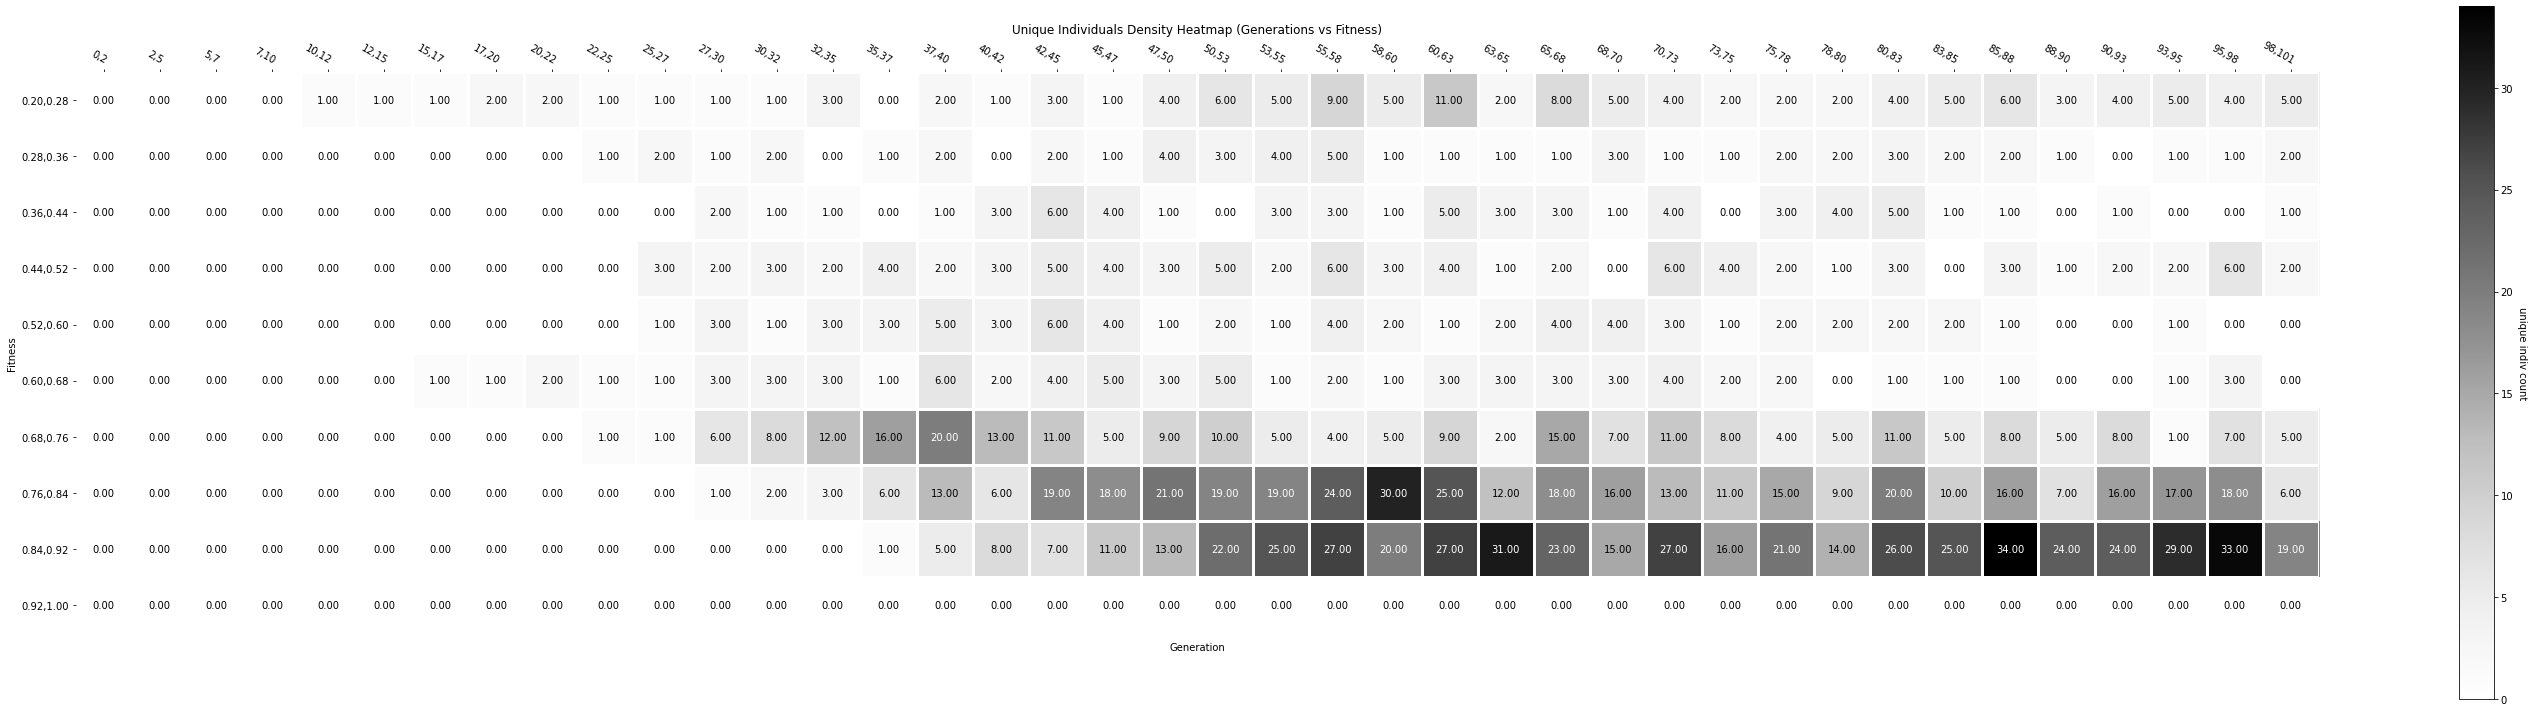

In [52]:
columns, rows = (40, 10)
plt.rcParams['figure.figsize'] = [columns, rows]
#plot_fit(data["epochs"], data['averages_all'], data['bests_all'])

fit_floor = 0.2
fit_ceil = 1.0
gen_floor = 0.0
gen_ceil = float(len(data['epochs']))
#pop_density_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)
#unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)
unique_indivs_heatmap(data["indivs_epochs"], data["indivs"], rows=rows, columns=columns, fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)
#unique_indivs_curve(data["indivs_epochs"], data["indivs"], fit_floor=fit_floor, fit_ceil=fit_ceil, gen_floor=gen_floor, gen_ceil=gen_ceil)
#plt.vlines([0,2,6,9,11,16,23,29,30,31,35,36,42,45,47,54,55,75],0,100,colors='red')

# Beyond this point is code for archive analysis, this is not refined. Do not use unless necessary

In [ ]:
archive_list = []
for i in run_number: 
    it = 1 
    try:
        while True:
            archive = load_archive(path, i, it)
            it += 1
    except:
        pass
    try:
        print(f"loading archive {it - 1} for run {i}")
        archive = load_archive(path, i, it - 1)
        for x in archive:
            if 'fitness' in archive[x]:
                archive_list.append([x, archive[x], archive[x]['fitness'], i])
    except:
        print(f"Run {i} has no archive")
archive_list.sort(key=lambda x : x[2])



In [ ]:
archive_list
with open('data.json', 'w') as f:
    json.dump(archive_list, f)

In [ ]:
it = 0
while it < 10:
    print(archive_list[it])
    it+=1

In [ ]:
def turn_to_expr(phenotype, tree):
    if phenotype == "":
        return tree
    
    if phenotype[0:9] == "multiply(":
        #print("multiply")
        phenotype = phenotype[9:]
        node = Node("*", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:14] == "divide_no_nan(":
        phenotype = phenotype[14:]
        node = Node("/", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "add(":
        phenotype = phenotype[4:]
        node = Node("+", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "pow(":
        phenotype = phenotype[4:]
        node = Node("^", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "subtract(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 2)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "grad":
        phenotype = phenotype[4:]
        node = Node("grad", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:4] == "beta":
        phenotype = phenotype[4:]
        node = Node("beta", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "alpha":
        phenotype = phenotype[5:]
        node = Node("alpha", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sigma":
        phenotype = phenotype[5:]
        node = Node("sigma", tree, 0)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "negative(":
        phenotype = phenotype[9:]
        node = Node("-", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:5] == "sqrt(":
        phenotype = phenotype[5:]
        node = Node("sqrt", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:7] == "square(":
        phenotype = phenotype[7:]
        node = Node("square", tree, 1)
        tree.insert(node)
        tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:2] == ", ":
        phenotype = phenotype[2:]
        return turn_to_expr(phenotype, tree)     
    elif phenotype[0] == ")":
        phenotype = phenotype[1:]
        return turn_to_expr(phenotype, tree)
    elif phenotype[0:9] == "constant(":
        if phenotype[9:12] == "0.0" or phenotype[9:13] == "1.0)" or phenotype[9:13] == "1.0,":
            node = Node(phenotype[9:12], tree, 0)
            phenotype = phenotype[12:]
            tree.insert(node)
            tree = tree.get_next()           
        else:
            node = Node(phenotype[9:9+14], tree, 0)
            phenotype = phenotype[9+14:]
            tree.insert(node)
            tree = tree.get_next()
        return turn_to_expr(phenotype, tree)
    else:
        raise Exception(phenotype)
        
def math_phenotype(phenotype):
    functions = trim_phenotype(phenotype)
    alpha_func_string = functions[1][8:-2]
    beta_func_string =functions[2][14:-2] 
    sigma_func_string =functions[3][21:-2] 
    grad_func_string = functions[-1][21:]
    
    for x in [alpha_func_string, beta_func_string, sigma_func_string, grad_func_string]:
        print(x)    
        turn_to_expr(x, Node("", None, 1)).to_string()

    return grad_func_string

for indiv in data['indivs']:
    math_phenotype(indiv['phenotype'])

In [ ]:
a = "multiply("
print(a[0:9])
print(a[9:])